<a href="https://colab.research.google.com/github/YichengShen/style-transfer-pytorch-implementations/blob/main/style_transfer_version1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Style Transfer Version 1**

## **Section 1: Setup**


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Import libraries**

In [ ]:
import os
import gc
import time

import numpy as np
import pandas as pd

# Image
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

# Files
from google.colab import files

Pytorch

In [ ]:
import torch
import torch.nn as nn
import torch.cuda as cuda
import torch.nn.functional as F
import torch.optim as optim

import torchvision.transforms as transforms
import torchvision.models as models

from torchsummary import summary

**Set seed for random operations**

In [ ]:
np.random.seed(0)
torch.manual_seed(0)

**Set GPU**

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on:", device)

Running on: cuda


**Set Project Root**

In [ ]:
ROOT = '/content/drive/MyDrive/style_transfer' # Project root path in Google Drive
ROOT = '/content/drive/MyDrive/Colab_Notebooks/CIS5810/style_transfer' # Project root path in Google Drive
CONTENT_IMAGE_DIR = 'images/content_images' # Directory of content images in Google Drive
STYLE_IMAGE_DIR = 'images/style_images' # Directory of style images in Google Drive
RESULT_IMAGE_DIR = 'images/result_images' # Directory of result images in Google Drive

## **Section 2: Prepare Images**

### **2.1. Image Loader Setup**

**Set output image size**

In [ ]:
# If GPU is available, use larger output image size
gpu_output_image_size = 512
cpu_output_image_size = 128

output_image_size = gpu_output_image_size if torch.cuda.is_available() \
                                          else cpu_output_image_size

**Process image:** Define Pytorch transforms

In [ ]:
transform = transforms.Compose([
    transforms.Resize((output_image_size, output_image_size)),  # Scale to our desired output size
    transforms.ToTensor()                                       # Convert PIL image to tensor
])

**Define Image Loader**

In [ ]:
def image_loader(image_path):
    image = Image.open(image_path)

    # Convert palettised image to RGB image
    if image.mode == 'P':
        image = image.convert('RGB')
    assert image.mode == 'RGB', "Image has to be RGB"

    image = torch.unsqueeze(transform(image), 0) 
    return image.to(device, torch.float)

### **2.2. Load Style and Content Images**

In [ ]:
STYLE_IMAGE_NAME = "wave.jpg"
CONTENT_IMAGE_NAME = "mountain.jpeg"

style_image_path = os.path.join(ROOT, STYLE_IMAGE_DIR, STYLE_IMAGE_NAME)
content_image_path = os.path.join(ROOT, CONTENT_IMAGE_DIR, CONTENT_IMAGE_NAME)

style_image = image_loader(style_image_path)
content_image = image_loader(content_image_path)

assert style_image.size() == content_image.size(), "Style image and content image must have the same size"

### **2.3. Display Images**

To show a image, we need to first convert its tensor to its PIL image type

In [ ]:
def tensor_to_PILimage(image_tensor):
    image = image_tensor.cpu().clone()  
    image = image.squeeze(0)      
    image = transforms.ToPILImage()(image)
    return image

**Show image**

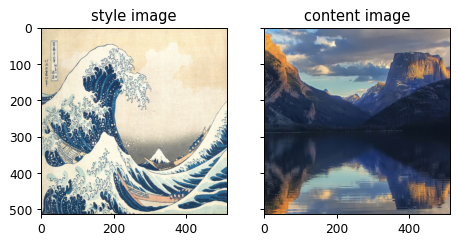

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.imshow(tensor_to_PILimage(style_image))
ax2.imshow(tensor_to_PILimage(content_image))
ax1.set_title('style image')
ax2.set_title('content image')
f.set_dpi(88)
f.show()

## **Section 3: Modeling**

### **3.1. Style Loss and Content Loss**

**Style Loss**

In [ ]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b = number of feature maps
    # (c,d)=dimensions of a f. map (N = c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

In [ ]:
class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

**Content Loss**

In [ ]:
class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [ ]:
class ContentLossL1(nn.Module):
    def __init__(self, target):
        super(ContentLossL1, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.l1_loss(input, self.target)
        return input

In [ ]:
class ContentLossSmoothL1(nn.Module):
    def __init__(self, target):
        super(ContentLossSmoothL1, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.smooth_l1_loss(input, self.target)
        return input

In [ ]:
class ContentLossHuberLoss(nn.Module):
    def __init__(self, target):
        super(ContentLossHuberLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.huber_loss(input, self.target)
        return input

### **3.2. CNN**

####3.2.1. Modeling

**Download the pre-trained CNN's weights**

VGG-19

In [ ]:
weights = models.VGG19_Weights.IMAGENET1K_V1
vgg_model = models.vgg19(weights=weights).features.to(device).eval()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

AlexNet

In [ ]:
alexnet_model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
alexnet_model = alexnet_model.features.to(device).eval()

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

**Normalization**

In [ ]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, image):
        # normalize img
        return (image - self.mean) / self.std

#### 3.2.2. Style and Content Loss Computation

**Define content and style layers**

In [ ]:
# desired depth layers to compute style/content losses in various models:
def get_content_style_layers(model_name='vgg'):
    # Return default content and style layers in VGG-19 model
    content_layers_default = ['conv_15']
    style_layers_default = ['conv_1', 'conv_3', 'conv_5', 'conv_9', 'conv_13', 'conv_16'] 

    # AlexNet
    if model_name == 'alexnet':
      content_layers_default = ['conv_5']
      style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4']

    return content_layers_default, style_layers_default

In [ ]:
def get_content_loss_fun(loss_type):
    if loss_type == 'l1':
      loss_fun = ContentLossL1
    elif loss_type == 'smooth_l1':
      loss_fun = ContentLossSmoothL1
    elif loss_type == 'huber':
      loss_fun = ContentLossHuberLoss
    elif loss_type == 'mse':
      loss_fun = ContentLoss
    else:
      raise RuntimeError('Unrecognized loss type: {}'.format(loss_type))
    return loss_fun

In [ ]:
def get_content_loss(target, loss_type='mse'):
  loss_fun = get_content_loss_fun(loss_type)
  content_loss = loss_fun(target)

  return content_loss

**Compute the loss for style and content**

In [ ]:
def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img, model_name, loss_type):
  
    # selected content & style layers
    content_layers, style_layers = get_content_style_layers(model_name)

    # define loss function
    content_loss_fun = get_content_loss_fun(loss_type)
    print(content_loss_fun)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)
    
    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        elif isinstance(layer, nn.AdaptiveAvgPool2d):
            name = 'aap_{}'.format(i)
        elif isinstance(layer, nn.Dropout):
            name = 'do_{}'.format(i)
        elif isinstance(layer, nn.Linear):
            name = 'lnr_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = get_content_loss(target, loss_type)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], content_loss_fun) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

#### 3.2.3. Style Transfer Training

**Prepare `input_image`**

In [ ]:
input_image = content_image.clone()

**Set optimizer**

In [ ]:
def get_input_optimizer(input_img, optimizer_name):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img])
    if optimizer_name == 'adam':
      optimizer = optim.Adam([input_img])
    elif optimizer_name == 'SGD':
      optimizer = optim.SGD([input_img], lr=0.01, momentum=0.8)
    return optimizer

**Style Transfer training**

num_steps recordings:

**VGG-19**
1. using LBFGS => num_epochs=[700, 800]
2. using SGD => num_epochs=[1200, 1300]
3. using ADAM => num_epochs=[1200, 1300]

In [ ]:
def garbage_collect():
    torch.cuda.empty_cache()
    gc.collect()

garbage_collect()

In [ ]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_epochs=700,
                       style_weight=1000000, content_weight=1, optimizer_name='LBFGS',
                       model_name='vgg', loss_type='mse'):
  
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std,
        style_img, content_img, model_name, loss_type)

    # We want to optimize the input and not the model parameters so we
    # update all the requires_grad fields accordingly
    input_img.requires_grad_(True)
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_img, optimizer_name)

    style_loss_history = []
    content_loss_history = []
    loss_history = []

    print('Optimizing..')
    epoch = [0]
    while epoch[0] <= num_epochs:

        def closure():
            # correct the values of updated input image
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()

            # with cuda.amp.autocast(device_type='cuda', dtype=torch.float16):
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight
            style_loss_history.append(style_score.item())
            content_loss_history.append(content_score.item())

            loss = style_score + content_score
            loss_history.append(loss.item())
            loss.backward()

            epoch[0] += 1
            if epoch[0] == 1 or epoch[0] % 50 == 0:
                print("Epoch {}:".format(epoch))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    with torch.no_grad():
        input_img.clamp_(0, 1)

    all_loss_history = [style_loss_history, content_loss_history, loss_history]

    return input_img, all_loss_history

In [ ]:
# Choices of optimizer: 'LBFGS', 'adam', 'SGD'
optimizer_name = 'LBFGS'
# Choices of models (used in layer selection): 'vgg', 'alexnet'
model_name = 'vgg'
# Choices of loss methods: 'mse', 'l1', 'smooth_l1', 'huber'
loss_type = 'mse'

start = time.time()
output_image, all_loss_history = run_style_transfer(vgg_model, 
                                                    cnn_normalization_mean, 
                                                    cnn_normalization_std, 
                                                    content_image, 
                                                    style_image, 
                                                    input_image, 
                                                    optimizer_name=optimizer_name,
                                                    model_name=model_name,
                                                    loss_type=loss_type)
end = time.time()
print(f'Training Duration: {end - start}')

Building the style transfer model..
<class '__main__.ContentLoss'>
Optimizing..


<ipython-input-57-6042817fe2e1>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-57-6042817fe2e1>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


Epoch [1]:
Style Loss : 61.600296 Content Loss: 9.476671

Epoch [50]:
Style Loss : 21.260820 Content Loss: 8.364307

Epoch [100]:
Style Loss : 11.575534 Content Loss: 7.611777

Epoch [150]:
Style Loss : 7.861838 Content Loss: 7.097328

Epoch [200]:
Style Loss : 5.978755 Content Loss: 6.706970

Epoch [250]:
Style Loss : 4.873276 Content Loss: 6.411309

Epoch [300]:
Style Loss : 4.137041 Content Loss: 6.172206

Epoch [350]:
Style Loss : 3.654079 Content Loss: 5.987355

Epoch [400]:
Style Loss : 3.293618 Content Loss: 5.848536

Epoch [450]:
Style Loss : 3.045499 Content Loss: 5.732415

Epoch [500]:
Style Loss : 2.867717 Content Loss: 5.622751

Epoch [550]:
Style Loss : 2.727454 Content Loss: 5.541946

Epoch [600]:
Style Loss : 2.624783 Content Loss: 5.461576

Epoch [650]:
Style Loss : 2.539258 Content Loss: 5.394229

Epoch [700]:
Style Loss : 2.473801 Content Loss: 5.334464

Training Duration: 73.28421235084534


#### 3.2.4. Results display and save

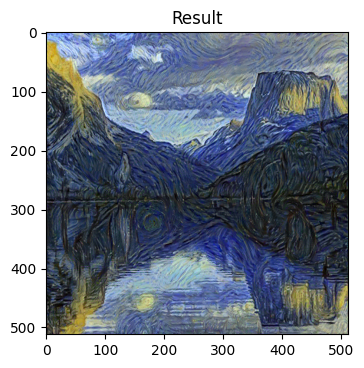

In [ ]:
sns.reset_orig()
plt.figure(dpi=100)
plt.imshow(tensor_to_PILimage(output_image))
plt.title('Result')
plt.show()

Save the result to result folder

In [ ]:
result = tensor_to_PILimage(output_image)
file_name = '{}_{}_{}_{}'.format(model_name, optimizer_name, loss_type, output_image_size)
# Set project ROOT at the beginning of this notebook
result_saving_path = os.path.join(ROOT, RESULT_IMAGE_DIR, f"{file_name}.jpg")
result.save(result_saving_path)

Download Image

In [ ]:
files.download(result_saving_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### 3.2.5. Plot loss

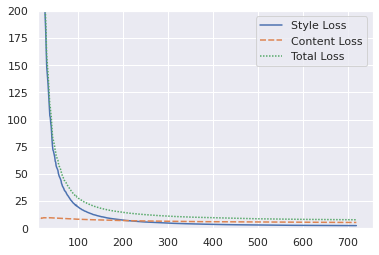

In [ ]:
style_loss_history, content_loss_history, loss_history = all_loss_history
loss_df = pd.DataFrame({'Style Loss': style_loss_history,
                        'Content Loss': content_loss_history,
                        'Total Loss': loss_history})

sns.set_theme()
g = sns.lineplot(data=loss_df)
g.set_xlim(10, None)
g.set_ylim(0, 200)
plt.show()

### 3.3. Comparisons of different optimizers and loss functions

#### 3.3.1. Loss trends for different optimizers

In [ ]:
losses = {}
output_images = {}
model_name = 'vgg'
loss_type = 'mse'

for optimizer_name in ['LBFGS', 'adam', 'SGD']:
    print(f'Training on optimizer {optimizer_name}')
    # Reset input 
    input_image = content_image.clone()
    # NST
    output_image, all_loss_history = run_style_transfer(vgg_model, 
                                  cnn_normalization_mean, 
                                  cnn_normalization_std, 
                                  content_image, 
                                  style_image, 
                                  input_image, 
                                  optimizer_name=optimizer_name,
                                  model_name=model_name,
                                  loss_type=loss_type,
                                  num_epochs=500)
    output_images[optimizer_name] = output_image
    losses[optimizer_name] = all_loss_history

Building the style transfer model..
<class '__main__.ContentLoss'>
Optimizing..


<ipython-input-28-6042817fe2e1>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-28-6042817fe2e1>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


Epoch [1]:
Style Loss : 16918.875000 Content Loss: 0.000000

Epoch [50]:
Style Loss : 59.856670 Content Loss: 9.421267

Epoch [100]:
Style Loss : 18.879751 Content Loss: 8.320880

Epoch [150]:
Style Loss : 10.527196 Content Loss: 7.535917

Epoch [200]:
Style Loss : 7.434099 Content Loss: 7.054811

Epoch [250]:
Style Loss : 5.734536 Content Loss: 6.648273

Epoch [300]:
Style Loss : 4.719904 Content Loss: 6.338418

Epoch [350]:
Style Loss : 4.027680 Content Loss: 6.113593

Epoch [400]:
Style Loss : 3.551324 Content Loss: 5.943427

Epoch [450]:
Style Loss : 3.215793 Content Loss: 5.784132

Epoch [500]:
Style Loss : 2.991483 Content Loss: 5.654356

Building the style transfer model..
<class '__main__.ContentLoss'>
Optimizing..
Epoch [1]:
Style Loss : 16918.875000 Content Loss: 0.000000

Epoch [50]:
Style Loss : 1542.144287 Content Loss: 9.035378

Epoch [100]:
Style Loss : 573.588013 Content Loss: 9.389881

Epoch [150]:
Style Loss : 339.251648 Content Loss: 9.428181

Epoch [200]:
Style Loss

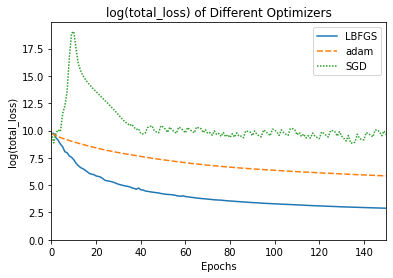

In [ ]:
loss_df = pd.DataFrame()
for optimizer_name in ['LBFGS', 'adam', 'SGD']:
    loss_df = pd.concat([loss_df, pd.DataFrame({optimizer_name: np.log(losses[optimizer_name][2])})])

g = sns.lineplot(data=loss_df)
g.set_xlim(0, 150)
g.set_ylim(0, )
plt.xlabel('Epochs')
plt.ylabel('log(total_loss)')
plt.title('log(total_loss) of Different Optimizers')
plt.show()

Plot the output images generated by different optimizers

<Figure size 600x400 with 0 Axes>

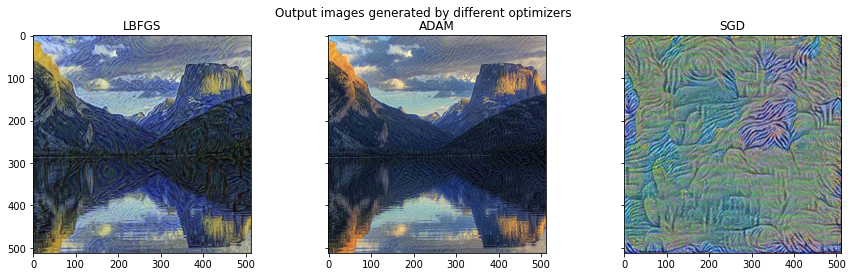

In [ ]:
rows = 1
columns = 3

sns.reset_orig()
plt.figure(dpi=100)

f, (ax1, ax2, ax3) = plt.subplots(rows, columns, sharey=True, figsize=(15, 4))
ax1.imshow(tensor_to_PILimage(output_images['LBFGS']))
ax2.imshow(tensor_to_PILimage(output_images['adam']))
ax3.imshow(tensor_to_PILimage(output_images['SGD']))

f.suptitle('Output images generated by different optimizers')
ax1.set_title('LBFGS')
ax2.set_title('ADAM')
ax3.set_title('SGD')
f.show()

#### 3.3.2. Loss trends for different loss functions

In [ ]:
losses_lossfunc = {}
outputs_lossfunc = {}
duration_lossfunc = {}
model_name = 'vgg'
optimizer_name = 'LBFGS'

for loss_type in ['l1', 'smooth_l1', 'huber', 'mse']:
    print(f'Training on {loss_type}')
    start = time.time()
    # Reset input 
    input_image = content_image.clone()
    # NST
    output_image, all_loss_history = run_style_transfer(vgg_model, 
                                              cnn_normalization_mean, 
                                              cnn_normalization_std, 
                                              content_image, 
                                              style_image, 
                                              input_image, 
                                              optimizer_name=optimizer_name,
                                              model_name=model_name,
                                              loss_type=loss_type)
    end = time.time()
    outputs_lossfunc[loss_type] = output_image
    losses_lossfunc[loss_type] = all_loss_history
    duration_lossfunc[loss_type] = end - start
    print(f'Time used for training is {duration_lossfunc[loss_type]}')

Training on l1
Building the style transfer model..
<class '__main__.ContentLossL1'>
Optimizing..
Epoch [1]:
Style Loss : 23001.560547 Content Loss: 0.000000



<ipython-input-57-6042817fe2e1>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-57-6042817fe2e1>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


Epoch [50]:
Style Loss : 145.448380 Content Loss: 3.369075

Epoch [100]:
Style Loss : 62.430672 Content Loss: 3.433068

Epoch [150]:
Style Loss : 39.846256 Content Loss: 3.411416

Epoch [200]:
Style Loss : 29.928715 Content Loss: 3.388870

Epoch [250]:
Style Loss : 24.639372 Content Loss: 3.381438

Epoch [300]:
Style Loss : 21.326155 Content Loss: 3.382827

Epoch [350]:
Style Loss : 19.031315 Content Loss: 3.377480

Epoch [400]:
Style Loss : 17.385618 Content Loss: 3.374408

Epoch [450]:
Style Loss : 16.053980 Content Loss: 3.373098

Epoch [500]:
Style Loss : 15.062360 Content Loss: 3.371200

Epoch [550]:
Style Loss : 14.241895 Content Loss: 3.369861

Epoch [600]:
Style Loss : 13.578030 Content Loss: 3.373792

Epoch [650]:
Style Loss : 13.034091 Content Loss: 3.370952

Epoch [700]:
Style Loss : 12.579039 Content Loss: 3.369912

Epoch [750]:
Style Loss : 12.204669 Content Loss: 3.371520

Epoch [800]:
Style Loss : 11.869769 Content Loss: 3.371242

Epoch [850]:
Style Loss : 11.597007 Cont

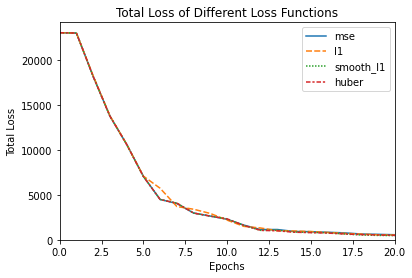

In [ ]:
loss_lossfunc_df = pd.DataFrame()
for loss_type in ['mse', 'l1', 'smooth_l1', 'huber']:
    loss_lossfunc_df = pd.concat([loss_lossfunc_df, pd.DataFrame({loss_type: losses_lossfunc[loss_type][2]})])

g = sns.lineplot(data=loss_lossfunc_df)
g.set_xlim(0, 20)
g.set_ylim(0,)
plt.xlabel('Epochs')
plt.ylabel('Total Loss')
plt.title('Total Loss of Different Loss Functions')
plt.show()

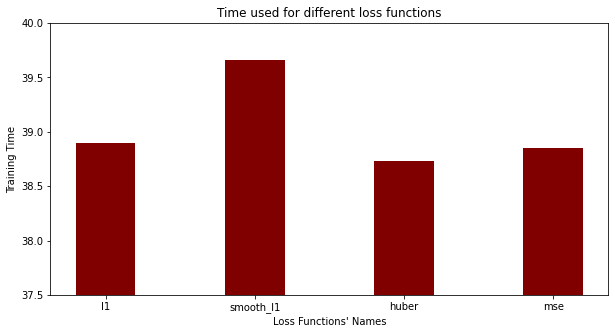

In [ ]:
models = list(duration_lossfunc.keys())
values = list(duration_lossfunc.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(models, values, color ='maroon',
        width = 0.4)
plt.ylim(37.5, 40)
plt.xlabel("Loss Functions' Names")
plt.ylabel("Training Time")
plt.title("Time used for different loss functions")
plt.show()

<Figure size 600x400 with 0 Axes>

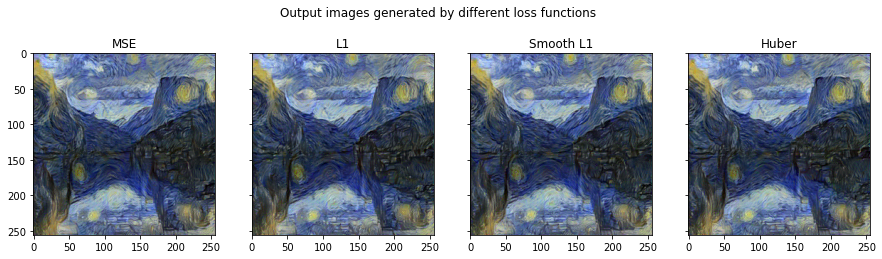

In [ ]:
rows = 1
columns = 4

sns.reset_orig()
plt.figure(dpi=100)

f, (ax1, ax2, ax3, ax4) = plt.subplots(rows, columns, sharey=True, figsize=(15, 4))
ax1.imshow(tensor_to_PILimage(outputs_lossfunc['mse']))
ax2.imshow(tensor_to_PILimage(outputs_lossfunc['l1']))
ax3.imshow(tensor_to_PILimage(outputs_lossfunc['smooth_l1']))
ax4.imshow(tensor_to_PILimage(outputs_lossfunc['huber']))

f.suptitle('Output images generated by different loss functions')
ax1.set_title('MSE')
ax2.set_title('L1')
ax3.set_title('Smooth L1')
ax4.set_title('Huber')

f.show()

#### 3.3.3. Loss trends for different backbone models

Training on VGG and AlexNet respectively with the same optimizer and loss function

In [ ]:
losses_models = {}
output_images_models = {}
duration_models = {}
optimizer_name = 'LBFGS'
loss_type = 'mse'
model = None

for model_name in ['vgg', 'alexnet']:
    print(f'Training on model {model_name}')
    start = time.time()
    # Reset input 
    input_image = content_image.clone()
    if model_name == 'vgg':
      model = vgg_model
    else:
      model = alexnet_model
    # NST
    output_image, all_loss_history = run_style_transfer(model, 
                                                        cnn_normalization_mean, 
                                                        cnn_normalization_std, 
                                                        content_image, 
                                                        style_image, 
                                                        input_image, 
                                                        optimizer_name=optimizer_name,
                                                        model_name=model_name,
                                                        loss_type=loss_type)
    end = time.time()
    output_images_models[model_name] = output_image
    losses_models[model_name] = all_loss_history
    duration_models[model_name] = end - start
    print(f'Time used for training is {duration_models[model_name]}')

Training on model vgg
Building the style transfer model..
<class '__main__.ContentLoss'>
Optimizing..


<ipython-input-28-6042817fe2e1>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-28-6042817fe2e1>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


Epoch [1]:
Style Loss : 16918.875000 Content Loss: 0.000000

Epoch [50]:
Style Loss : 57.927402 Content Loss: 9.386202

Epoch [100]:
Style Loss : 19.484665 Content Loss: 8.373634

Epoch [150]:
Style Loss : 10.761613 Content Loss: 7.634273

Epoch [200]:
Style Loss : 7.289789 Content Loss: 7.094096

Epoch [250]:
Style Loss : 5.702365 Content Loss: 6.740808

Epoch [300]:
Style Loss : 4.708143 Content Loss: 6.434762

Epoch [350]:
Style Loss : 4.044194 Content Loss: 6.198651

Epoch [400]:
Style Loss : 3.577347 Content Loss: 5.996675

Epoch [450]:
Style Loss : 3.234852 Content Loss: 5.843971

Epoch [500]:
Style Loss : 3.001953 Content Loss: 5.713646

Epoch [550]:
Style Loss : 2.821162 Content Loss: 5.615695

Epoch [600]:
Style Loss : 2.690248 Content Loss: 5.529540

Epoch [650]:
Style Loss : 2.593845 Content Loss: 5.455604

Epoch [700]:
Style Loss : 2.514635 Content Loss: 5.393480

Time used for training is 73.12183713912964
Training on model alexnet
Building the style transfer model..
<clas

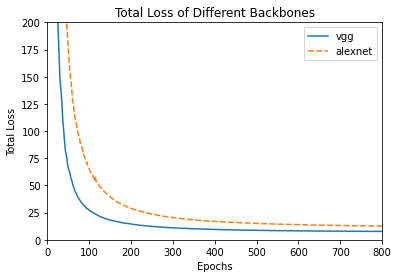

In [ ]:
loss_models_df = pd.DataFrame()
for model_name in ['vgg', 'alexnet']:
    loss_models_df = pd.concat([loss_models_df, pd.DataFrame({model_name: losses_models[model_name][2]})])

g = sns.lineplot(data=loss_models_df)
g.set_xlim(0, 800)
g.set_ylim(0, 200)
plt.xlabel('Epochs')
plt.ylabel('Total Loss')
plt.title('Total Loss of Different Backbones')
plt.show()

<Figure size 600x400 with 0 Axes>

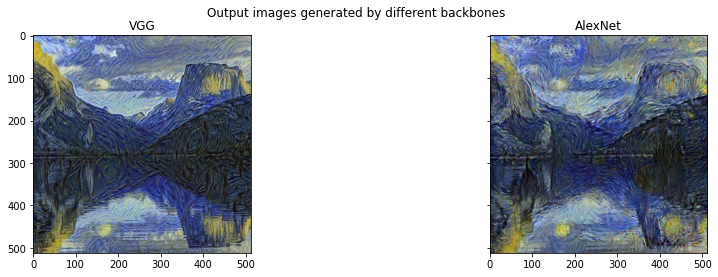

In [ ]:
rows = 1
columns = 2

sns.reset_orig()
plt.figure(dpi=100)

f, (ax1, ax2) = plt.subplots(rows, columns, sharey=True, figsize=(15, 4))
ax1.imshow(tensor_to_PILimage(output_images_models['vgg']))
ax2.imshow(tensor_to_PILimage(output_images_models['alexnet']))

f.suptitle('Output images generated by different backbones')
ax1.set_title('VGG')
ax2.set_title('AlexNet')

f.show()

Changing the images to larger sizes

In [ ]:
gpu_output_image_size = 1024
cpu_output_image_size = 256

output_image_size = gpu_output_image_size if torch.cuda.is_available() \
                                          else cpu_output_image_size

transform = transforms.Compose([
    transforms.Resize((output_image_size, output_image_size)),  # Scale to our desired output size
    transforms.ToTensor()                                       # Convert PIL image to tensor
])

style_image = image_loader(style_image_path)
content_image = image_loader(content_image_path)

assert style_image.size() == content_image.size(), "Style image and content image must have the same size"

In [ ]:
losses_models = {}
output_images_models = {}
duration_models = {}
optimizer_name = 'LBFGS'
loss_type = 'mse'
model = None

for model_name in ['vgg', 'alexnet']:
    print(f'Training on model {model_name}')
    # Reset input 
    input_image = content_image.clone()
    start = time.time()

    if model_name == 'vgg':
      model = vgg_model
    else:
      model = alexnet_model
    # NST
    output_image, all_loss_history = run_style_transfer(model, 
                                                        cnn_normalization_mean, 
                                                        cnn_normalization_std, 
                                                        content_image, 
                                                        style_image, 
                                                        input_image, 
                                                        optimizer_name=optimizer_name,
                                                        model_name=model_name,
                                                        loss_type=loss_type)
    end = time.time()
    output_images_models[model_name] = output_image
    losses_models[model_name] = all_loss_history
    duration_models[model_name] = end - start
    print(f'Time used for training is {duration_models[model_name]}')

Training on model vgg
Building the style transfer model..
<class '__main__.ContentLoss'>
Optimizing..


<ipython-input-22-6042817fe2e1>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-22-6042817fe2e1>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


Epoch [1]:
Style Loss : 44712.054688 Content Loss: 0.000000

Epoch [50]:
Style Loss : 743.254700 Content Loss: 5.505074

Epoch [100]:
Style Loss : 303.388702 Content Loss: 5.200451

Epoch [150]:
Style Loss : 206.580826 Content Loss: 4.882966

Epoch [200]:
Style Loss : 166.593124 Content Loss: 4.703465

Epoch [250]:
Style Loss : 142.005432 Content Loss: 4.491222

Epoch [300]:
Style Loss : 126.013313 Content Loss: 4.325592

Epoch [350]:
Style Loss : 113.590553 Content Loss: 4.235981

Epoch [400]:
Style Loss : 103.598930 Content Loss: 4.114017

Epoch [450]:
Style Loss : 95.881935 Content Loss: 4.030758

Epoch [500]:
Style Loss : 87.085945 Content Loss: 4.005240

Epoch [550]:
Style Loss : 79.046959 Content Loss: 3.962717

Epoch [600]:
Style Loss : 73.532768 Content Loss: 4.008995

Epoch [650]:
Style Loss : 67.306053 Content Loss: 3.972409

Epoch [700]:
Style Loss : 58.132282 Content Loss: 4.008880

Time used for training is 292.7221586704254
Training on model alexnet
Building the style tra

Training Duration for VGG model is 292.7221586704254


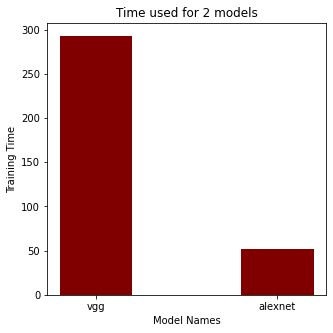

In [ ]:
models = list(duration_models.keys())
values = list(duration_models.values())
  
fig = plt.figure(figsize = (5, 5))
print(f'Training Duration for VGG model is {values[0]}')
# creating the bar plot
plt.bar(models, values, color ='maroon',
        width = 0.4)
plt.xlabel("Model Names")
plt.ylabel("Training Time")
plt.title("Time used for 2 models")
plt.show()

<Figure size 600x400 with 0 Axes>

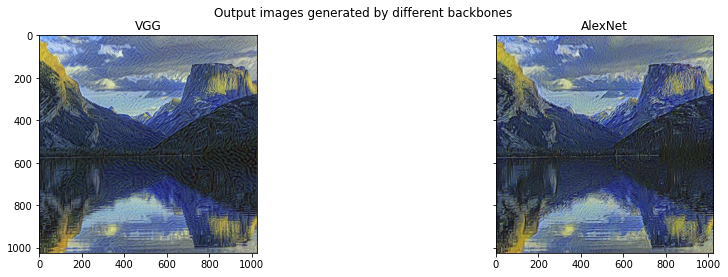

In [ ]:
rows = 1
columns = 2

sns.reset_orig()
plt.figure(dpi=100)

f, (ax1, ax2) = plt.subplots(rows, columns, sharey=True, figsize=(15, 4))
ax1.imshow(tensor_to_PILimage(output_images_models['vgg']))
ax2.imshow(tensor_to_PILimage(output_images_models['alexnet']))

f.suptitle('Output images generated by different backbones')
ax1.set_title('VGG')
ax2.set_title('AlexNet')

f.show()